<a href="https://colab.research.google.com/github/WilliamLu1999/Data-Projects/blob/main/reddit_api_sentiment_analysis_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis & Statistical Tests & Text Classification on Reddit's API Charging Policy

### Table of Contents
* [Introduction](#section-1)
* [Ask: Questions, Hypothesis](#section-2)
* [Prepare: Fetch Data](#section-3)
* [Process: Clean Data](#section-4)
* [Analyze: Sentiment Analysis, Statistical Tests, and Text Classification Spark](#section-5)
* [Summary](#section-6)




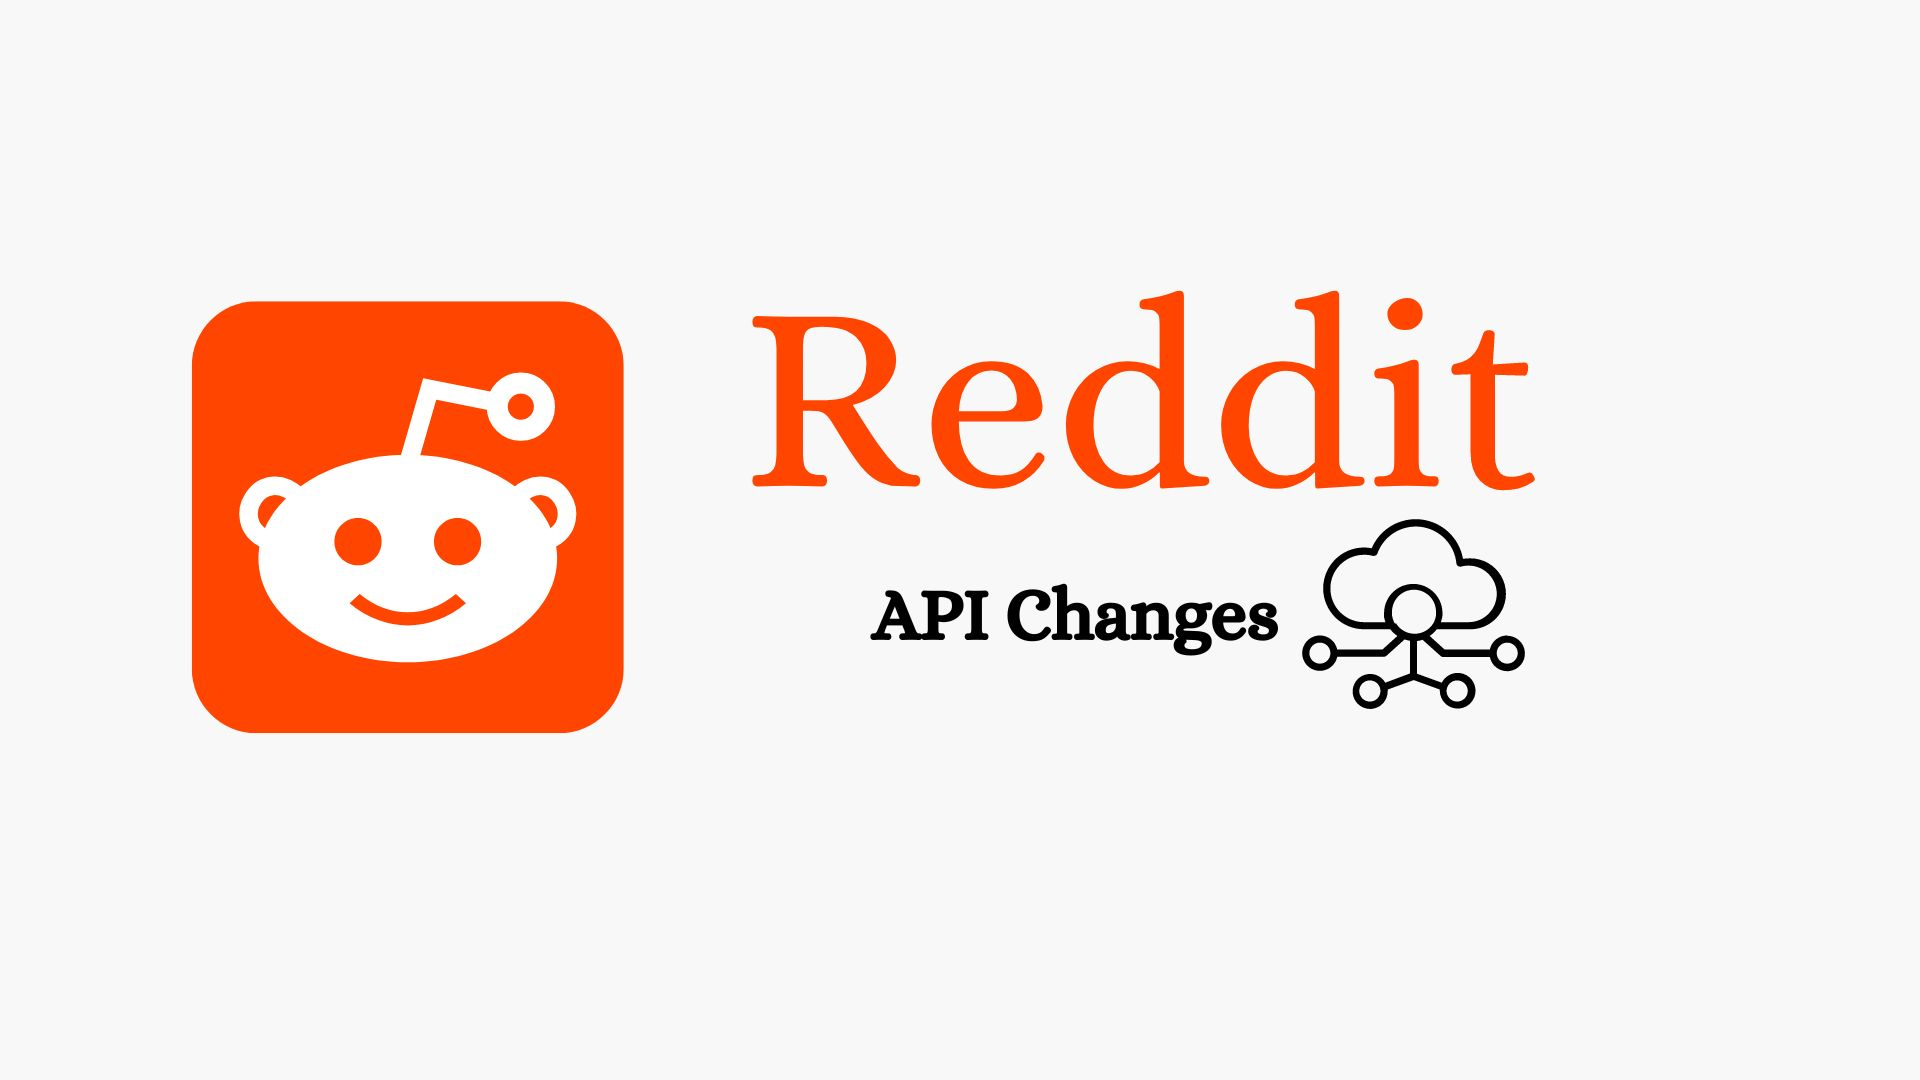


*Retrieved from: https://blogiestools.com/reddit-api-changes/*


<a id="section-1"></a>
### Introduction

*A. Backgroud*


Reddit is one of the biggest social media platforms that consists tons of niches (subreddits), covering a myriad of topics. Users (redditors) can create, share, comment, vote,etc. contents on Reddit.

*B. What happened?*

However, in April 2023, Reddit announced a new policy, which mainly stated that Reddit would start to charge third-party-applications for using its application-programming interface (API). API is a way for two or more computer programs to communicate with each other. It is a type of software interface, offering a service to other pieces of software. <wiki> Reddit's API was free to use since 2005 till 2023.

Now many applications that provide great service by adopting the free use of Reddit's API before are starting to shut down. For example, Apollo ReddPlanet and Sync (both are applications that provide a smooth and beautiful interface for browsing Reddit contents). Besides business shutting down, redditors also protest against this move -- nearly 9,000 subreddits went dark as an act of rebellion starting June 12, some of which with 30 million subscribers.


*C. Why this happened?*

According to Reddit CEO Steve Huffman, big tech companies such as Google, Microsoft, and OpenAI are using Reddit's contents to train LLM and for other AI usage freely. It's unsustainable if Reddit continues not charging any cost for its API.


*D. Souces:*

https://www.entrepreneur.com/business-news/reddit-blackout-protests-explained-api-changes-ceo-and/454629

https://www.zdnet.com/article/reddit-is-in-danger-of-a-death-spiral/


<a id="section-2"></a>
### Ask: Questions, Hypothesis
A. Questions

1.   What are the major sentiments of this topic?
2.   Is it a good move or a bad move for Reddit?

B. Hypothesis


1.   Angry and disappointment are the main sentiments of the comments.
2.   People will use them less frequently according to their comments; they will surf other websites as a substitution.
3.   It's in general a bad move at first, but the problem will be sorted out as time goes by since users rely on Reddit too much. Reddit's contents are great in many ways.
4.   Sarcasm in comments occur also quite frequently.




<a id="section-3"></a>
### Prepare: Fetch Data


To fetch the appropriate data, I use the YouTube API, which is free in contrast, to download comments from several videos about Reddit's API charging policy and change.

There are not too many videos about this, and since the issue is still hot so the contents of these may be a bit similar. However, I decide to add more data in the next few months to analyze people's emotions on this issue more.

In [ ]:
pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 4.7 MB/s eta 0:00:00


In [ ]:
pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285397 sha256=e98f99b88b5c34e075565fb686d781e9e1dd3220a5975f33db3b49707f8f600a
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import csv
import seaborn as sns

# import functions for data preprocessing & data preparation
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import for sentiment analysis
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import string
from string import punctuation
import nltk
import re
import contractions
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

# fetch YouTube Data
from googleapiclient.discovery import build

# spark
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import functions as func
from pyspark.sql.types import StringType,FloatType
import pyspark.sql.functions as F
from itertools import combinations
import pyspark
import time
import random
import itertools
from wordcloud import WordCloud
from scipy.stats import shapiro
import pylab
import scipy.stats as stats
from scipy.stats import mannwhitneyu
print('packages ready')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


packages ready


In [ ]:
from googleapiclient.discovery import build
# Youtube API Key is stored in this text file. Not directly showing it here for safety reason.
with open('/content/drive/MyDrive/data/youtube_API.txt', 'r') as file:
    file_content = file.read()

api_key = str(file_content)


def get_video_comments(video_id):
    youtube = build('youtube', 'v3', developerKey=api_key)

    comments = []
    nextPageToken = None

    while True:
        response = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            maxResults=100,
            pageToken=nextPageToken
        ).execute()

        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comment_id = item['snippet']['topLevelComment']['id']
            comment_stats = item['snippet']['topLevelComment']['snippet']['likeCount']
            comment_reply_stats = item['snippet']['totalReplyCount']

            comments.append({
                'comment': comment,
                'upvotes': int(comment_stats),
                'downvotes': 0,  # Downvotes are not directly available in commentThreads API
                'replies': int(comment_reply_stats)
            })

        nextPageToken = response.get('nextPageToken')

        if not nextPageToken:
            break

    return comments

In [ ]:
# comment out below for future runs
# Enter video ID
video_id1 = "Ch6zNEq9fwM"
# Call the function to retrieve comments
comments1 = get_video_comments(video_id1)
video_id2 = "fBruoybHryU"
comments2 = get_video_comments(video_id2)
video_id3 = "VO-iMK-1ljY"
comments3 = get_video_comments(video_id3)
video_id4 = "vGG_zmcSHJo"
comments4 = get_video_comments(video_id4)
video_id5 = "U06rCBIKM5M"
comments5 = get_video_comments(video_id5)
video_id6 = "nXYOdnn_FLo"
comments6 = get_video_comments(video_id6)
video_id7 = "LxlVe1xwPQc"
comments7 = get_video_comments(video_id7)
video_id8 = 'zL0yFvkLMQc'
comments8 = get_video_comments(video_id8)
video_id9 = 'bXRVRu-qWFU'
comments9 = get_video_comments(video_id9)
video_id10 = 'TEVzqTi_cls'
comments10 = get_video_comments(video_id10)
video_id11 = 'WusFlgO8FX0'
comments11 = get_video_comments(video_id11)

comments = comments1+comments2+comments3+comments4+comments5+comments6+comments7+comments8+comments9+comments10+comments11
# Specify the output CSV file path on Google Drive
csv_file_path = '/content/drive/MyDrive/data/reddit_api_comments.csv'

In [ ]:
# transform the list of comments to a dataframe
df = pd.DataFrame(comments)
# store the dataframe as a csv
df.to_csv(csv_file_path,index=False)

In [ ]:
video_id12 = 'l5eD7Q7KNhU'
comments12 = get_video_comments(video_id12)
video_id13 = 'ikhGvUpdu40'
comments13 = get_video_comments(video_id13)
video_id14 = 'LEGCHnoEsLM'
comments14 = get_video_comments(video_id14)
video_id15 = 'JqL-G3GFqRU'
comments15 = get_video_comments(video_id15)
video_id16 = 'OoFueyYXh80'
comments16 = get_video_comments(video_id16)
video_id17 = 'mPhxkvdWWf0'
comments17 = get_video_comments(video_id17)
video_id18 = '6pTlCsAMM1o'
comments18 = get_video_comments(video_id18)
video_id19 = '0csUacUpDrc'
comments19 = get_video_comments(video_id19)
video_id20 = 'h6JJSkMGdZ0'
comments20 = get_video_comments(video_id20)


In [ ]:
comments_part2 = comments12+comments13+comments14+comments15+comments16+comments17+comments18+comments19+comments20
# Specify the output CSV file path on Google Drive
csv_file_path_2 = '/content/drive/MyDrive/data/reddit_api_comments_2.csv'

In [ ]:
# transform the list of comments to a dataframe
df2 = pd.DataFrame(comments_part2)
# store the dataframe as a csv
df2.to_csv(csv_file_path_2,index=False)

In [ ]:
video_id21 = '-zthI7doQDk'
comments21 = get_video_comments(video_id21)
video_id22 = 'JHDrK2E62SA'
comments22 = get_video_comments(video_id22)
video_id23 = '6UsQQJkoKQE'
comments23 = get_video_comments(video_id23)
video_id24 = 'VYij7Ic5p8k'
comments24 = get_video_comments(video_id24)
video_id25 = 'bBhDWTZDH9c'
comments25 = get_video_comments(video_id25)
comments_part3 = comments21+comments22+comments23+comments24+comments25
# Specify the output CSV file path on Google Drive
csv_file_path_3 = '/content/drive/MyDrive/data/reddit_api_comments_3.csv'
# transform the list of comments to a dataframe
df3 = pd.DataFrame(comments_part3)
# store the dataframe as a csv
df3.to_csv(csv_file_path_3,index=False)

In [ ]:
# run this for every new run
rc1 = pd.read_csv('/content/drive/MyDrive/data/reddit_api_comments.csv')
rc2 = pd.read_csv('/content/drive/MyDrive/data/reddit_api_comments_2.csv')
rc3 = pd.read_csv('/content/drive/MyDrive/data/reddit_api_comments_3.csv')
# Concatenate the DataFrames vertically
rc = pd.concat([rc1, rc2, rc3])
rc

,comment,upvotes,downvotes,replies
0,You have to laugh. All those &#39;moderators&...,0.0,0.0,0.0
1,But imagine not using an ad blocker in the yea...,0.0,0.0,0.0
2,The thing about Apollo many people simply don&...,1.0,0.0,0.0
3,Reddit gives you the information you need and ...,0.0,0.0,0.0
4,reddit has fallen,0.0,0.0,0.0
...,...,...,...,...
4592,hello,1.0,0.0,0.0
4593,Based and foss pilled,10.0,0.0,0.0
4594,<b>W VIDEO</b>,4.0,0.0,0.0
4595,Hi :),1.0,0.0,0.0


<a id="section-4"></a>
### Process: Clean Data

At the first glance, you see some comments have special charatcers (like the first comment), some have capital letters, and some comments may not deliver any sentiment values (like 'First'). Hence, let's make the comments clean first!




*   Convert all comments to lower letters
*   Remove HTML and urls from comments
*   Remove non-alphabetical characters
*   Perform contractions
*   Remove extra space
*   Remove stop words
*   Perform lemmatization

In [ ]:
# find the average comment length before cleaning
rc['comment before'] = rc['comment']
pre_length = rc['comment'].apply(len).mean()
rc['comment'] = rc['comment'].astype(str)
# convert all reviews to lowercase
rc['comment']= rc['comment'].str.lower()
# remove urls from the reviews
rc["comment"] = rc["comment"].str.replace(r'\s*https?://\S+(\s+|$)', '').str.strip()
# remove htmls tag from the reviews
rc['comment'] = rc['comment'].str.replace(r'<[^<>]*>', '', regex=True)
# remove numerics
rc['comment'] = rc['comment'].str.replace('\d+', '',regex=True)
# remove non-alphabetical characters
rc['comment'] = rc['comment'].str.replace('[^a-zA-Z0-9]', ' ', regex=True)
# perform contractions
rc['comment'] = rc['comment'].apply(lambda x: contractions.fix(x))
# remove extra space
rc['comment'] = rc['comment'].str.strip()
stop = nltk.corpus.stopwords.words('english')
rc['comment withno stopwords'] = rc['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
lmtzr = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN,"V":wordnet.VERB,"J":wordnet.ADJ,"R":wordnet.ADV}
# define a lemmatization function and then we can pass in a panda series to perform lemmatization
def lemmatization(series):
    pos_tagged = nltk.pos_tag(series.split())
    return ' '.join([lmtzr.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged])
rc['comment final'] = rc['comment withno stopwords'].apply(lambda x: lemmatization(x))

<ipython-input-15-ed538066761b>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  rc["comment"] = rc["comment"].str.replace(r'\s*https?://\S+(\s+|$)', '').str.strip()


In [ ]:
post_length = rc['comment'].apply(len).mean()
print("Calculating the average comment length......")
print(f"Before cleaning: {pre_length}, after cleaning: {post_length}, length difference: {pre_length-post_length}")
rc.drop(columns = ["comment"])

Calculating the average comment length......
Before cleaning: 172.8824584592145, after cleaning: 166.76104607250755, length difference: 6.121412386706936


,upvotes,downvotes,replies,comment before,comment withno stopwords,comment final
0,0.0,0.0,0.0,You have to laugh. All those &#39;moderators&...,laugh moderators enforce code conduct little f...,laugh moderator enforce code conduct little fi...
1,0.0,0.0,0.0,But imagine not using an ad blocker in the yea...,imagine using ad blocker year,imagine use ad blocker year
2,1.0,0.0,0.0,The thing about Apollo many people simply don&...,thing apollo many people simply realize actual...,thing apollo many people simply realize actual...
3,0.0,0.0,0.0,Reddit gives you the information you need and ...,reddit gives information need wrong time secon...,reddit give information need wrong time second...
4,0.0,0.0,0.0,reddit has fallen,reddit fallen,reddit fallen
...,...,...,...,...,...,...
4592,1.0,0.0,0.0,hello,hello,hello
4593,10.0,0.0,0.0,Based and foss pilled,based foss pilled,base fo pilled
4594,4.0,0.0,0.0,<b>W VIDEO</b>,w video,w video
4595,1.0,0.0,0.0,Hi :),hi,hi


<a id="section-5"></a>
### Analyze: Sentiment Analysis & Statistical Tests & Text Classification through Spark

#### Sentiment Analysis and Visualizations

NLTK's VADER: Assign sentiment score to each comment and classify comments into three categories - positive, negative, and neutral.

In [ ]:
# this approach does not consider relationships between words
sentiments = SentimentIntensityAnalyzer()
rc["positive"] = [sentiments.polarity_scores(i)["pos"] for i in rc["comment final"]]
rc["negative"] = [sentiments.polarity_scores(i)["neg"] for i in rc["comment final"]]
rc["neutral"] = [sentiments.polarity_scores(i)["neu"] for i in rc["comment final"]]
rc['compound'] = [sentiments.polarity_scores(i)["compound"] for i in rc["comment final"]]
score = rc["compound"].values
sentiment = []
for i in score:
    if i >= 0.05 :
        sentiment.append('positive')
    elif i <= -0.05 :
        sentiment.append('negative')
    else:
        sentiment.append('neutral')
rc["sentiment"] = sentiment
rc.head()


,comment,upvotes,downvotes,replies,comment before,comment withno stopwords,comment final,positive,negative,neutral,compound,sentiment
0,you have to laugh all those moderators ...,0.0,0.0,0.0,You have to laugh. All those &#39;moderators&...,laugh moderators enforce code conduct little f...,laugh moderator enforce code conduct little fi...,0.129,0.226,0.645,-0.4019,negative
1,but imagine not using an ad blocker in the year,0.0,0.0,0.0,But imagine not using an ad blocker in the yea...,imagine using ad blocker year,imagine use ad blocker year,0.000,0.000,1.000,0.0000,neutral
2,the thing about apollo many people simply don ...,1.0,0.0,0.0,The thing about Apollo many people simply don&...,thing apollo many people simply realize actual...,thing apollo many people simply realize actual...,0.000,0.136,0.864,-0.4588,negative
3,reddit gives you the information you need and ...,0.0,0.0,0.0,Reddit gives you the information you need and ...,reddit gives information need wrong time secon...,reddit give information need wrong time second...,0.000,0.296,0.704,-0.8508,negative
4,reddit has fallen,0.0,0.0,0.0,reddit has fallen,reddit fallen,reddit fallen,0.000,0.714,0.286,-0.3612,negative


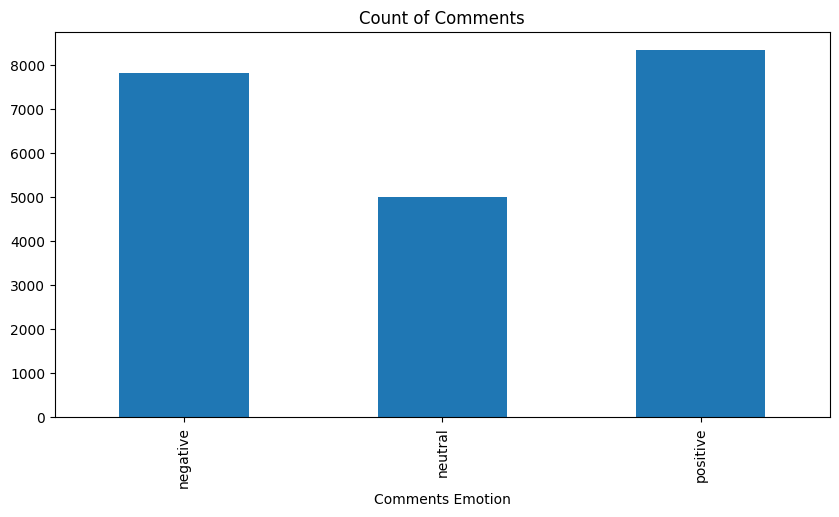

In [ ]:
ax = rc['sentiment'].value_counts().sort_index()\
.plot(kind ='bar',title ='Count of Comments',figsize=(10,5))
ax.set_xlabel('Comments Emotion')
plt.show()

(0.0, 500.0)

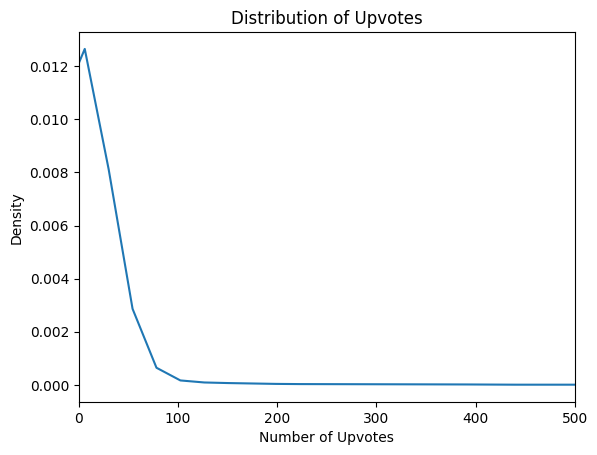

In [ ]:
ax2 = rc['upvotes'].plot(kind='kde',title='Distribution of Upvotes')
ax2.set_xlabel('Number of Upvotes')
plt.xlim([0, 500])

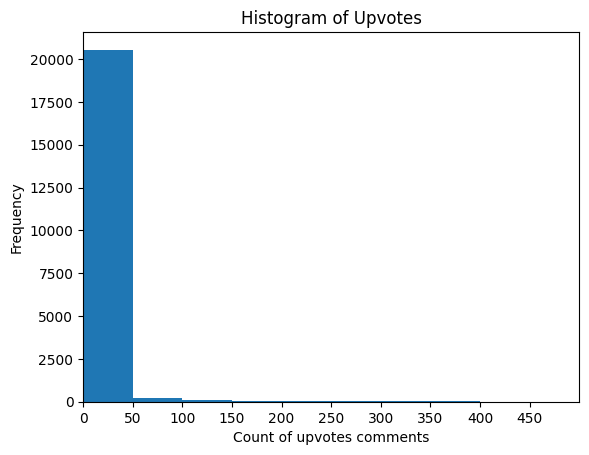

In [ ]:
plt.hist(rc['upvotes'], bins=range(int(min(rc['upvotes'])), int(max(rc['upvotes'])) + 2, 50))
# Set the title and axis labels
plt.title('Histogram of Upvotes')
plt.xlabel('Count of upvotes comments')
plt.ylabel('Frequency')
plt.xlim(0,500)
# Display the histogram
plt.xticks(range(0, 500, 50))
plt.show()

Text(0.5, 0.98, 'Compound Scores of Reddit comments Distribution')

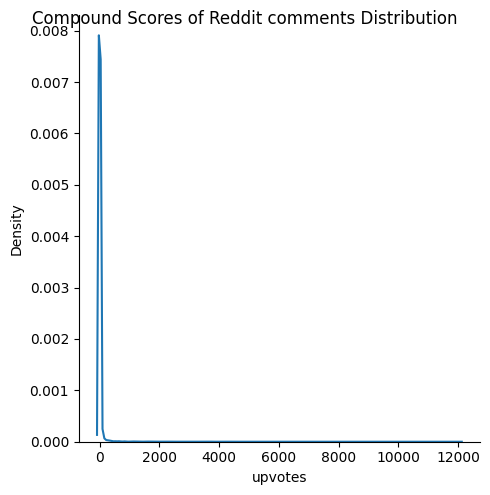

In [ ]:
rc.reset_index(drop=True, inplace=True) # drop old duplicated index
ax3 = sns.displot(data=rc,x='upvotes', kind="kde",legend=False)
ax3.fig.suptitle('Compound Scores of Reddit comments Distribution')

From the above NLTK's VADER results, you can see that there is a high percentage of 'positive' comments for this issue. However, since this issue was not perceived like how I felt on the internet, many so-called positive comments might be sarcastic.

Therefore, we now use ROBERTA transformer model from huggingface. It will consider contexts and may be able to realize if a comment is sarcastic or not.

In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.4 MB/s eta 0:00:00


In [ ]:
# perform transfer learning
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
roberta_tranformer  = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(roberta_tranformer)
roberta = AutoModelForSequenceClassification.from_pretrained(roberta_tranformer)

In [ ]:
# run roberta model for all comments
def roberta_polarity(sentence):
  encoded_comment = tokenizer(sentence,return_tensors='pt') # encoding the comment first so that the model will understand
  pred = roberta(**encoded_comment)
  sentiments = pred[0][0].detach().numpy() # make it into numpy so that we can store the results
  sentiments = softmax(sentiments) # softmax it since roberta model does not have the softmax layer
  sentiments_dict = {
      'negative_roberta':sentiments[0],
      'neutral_roberta':sentiments[1],
      'positive_roberta':sentiments[2]
  }
  return sentiments_dict

In [ ]:
# getting sentiments scores from a transformer model
roberta_pos =[]
roberta_neg =[]
roberta_neu =[]
for i , row in rc.iterrows():
  try:
    temp = roberta_polarity(row['comment'])
    temp_neg= temp['negative_roberta'] # since the given result is like {}
    temp_pos= temp['positive_roberta']
    temp_neu= temp['neutral_roberta']
    roberta_pos.append(temp_pos)
    roberta_neg.append(temp_neg)
    roberta_neu.append(temp_neu)
  except RuntimeError:
    print(i,temp)
    roberta_pos.append(temp_pos)
    roberta_neg.append(temp_neg)
    roberta_neu.append(temp_neu)
# add these two predicted results to the dataframe
rc['roberta positive'] = roberta_pos
rc['roberta negative'] = roberta_neg
rc['roberta neutral'] = roberta_neu

730 {'negative_roberta': 0.056283593, 'neutral_roberta': 0.30231956, 'positive_roberta': 0.6413969}
1670 {'negative_roberta': 0.6676686, 'neutral_roberta': 0.29347906, 'positive_roberta': 0.038852338}
1791 {'negative_roberta': 0.02320605, 'neutral_roberta': 0.37217686, 'positive_roberta': 0.60461706}
3820 {'negative_roberta': 0.4534665, 'neutral_roberta': 0.44927758, 'positive_roberta': 0.09725594}
4317 {'negative_roberta': 0.947347, 'neutral_roberta': 0.045474257, 'positive_roberta': 0.007178743}
4596 {'negative_roberta': 0.47741276, 'neutral_roberta': 0.4662861, 'positive_roberta': 0.05630119}
5172 {'negative_roberta': 0.8366844, 'neutral_roberta': 0.15020752, 'positive_roberta': 0.01310815}
7293 {'negative_roberta': 0.6501741, 'neutral_roberta': 0.28864762, 'positive_roberta': 0.061178267}
8813 {'negative_roberta': 0.8963766, 'neutral_roberta': 0.09459802, 'positive_roberta': 0.00902526}
10650 {'negative_roberta': 0.39433885, 'neutral_roberta': 0.5642443, 'positive_roberta': 0.04141

Using the transformers pipelines to get sentiments

In [ ]:
from transformers import pipeline
transformer_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [ ]:
sentiment_pipeline =[]
score_pipeline = []
for i , row in rc.iterrows():
  try:
    temp = transformer_pipeline(row['comment'])
    temp_label = temp[0]['label'] # since the given result is like [{,}]
    temp_score = temp[0]['score']
    sentiment_pipeline.append(temp_label)
    score_pipeline.append(temp_score)
  except RuntimeError:
    print(i,temp)
    sentiment_pipeline.append(temp_label)
    score_pipeline.append(temp_score)
# add these two predicted results to the dataframe
rc['sentiment (pipeline)'] = sentiment_pipeline
rc['score (pipeline)'] = score_pipeline

Token indices sequence length is longer than the specified maximum sequence length for this model (578 > 512). Running this sequence through the model will result in indexing errors


730 [{'label': 'NEGATIVE', 'score': 0.770187497138977}]
1670 [{'label': 'NEGATIVE', 'score': 0.999686598777771}]
1791 [{'label': 'POSITIVE', 'score': 0.9423678517341614}]
4317 [{'label': 'NEGATIVE', 'score': 0.9973094463348389}]
5172 [{'label': 'NEGATIVE', 'score': 0.99741131067276}]
8813 [{'label': 'NEGATIVE', 'score': 0.9995983242988586}]
10650 [{'label': 'NEGATIVE', 'score': 0.9906606078147888}]
12474 [{'label': 'NEGATIVE', 'score': 0.9993651509284973}]
12506 [{'label': 'POSITIVE', 'score': 0.9889842867851257}]
15266 [{'label': 'NEGATIVE', 'score': 0.9986733198165894}]
17379 [{'label': 'NEGATIVE', 'score': 0.9974675178527832}]
17478 [{'label': 'NEGATIVE', 'score': 0.9278539419174194}]
17617 [{'label': 'NEGATIVE', 'score': 0.9936038851737976}]
17754 [{'label': 'NEGATIVE', 'score': 0.9974707365036011}]
17797 [{'label': 'NEGATIVE', 'score': 0.9995429515838623}]
18285 [{'label': 'NEGATIVE', 'score': 0.9983236193656921}]
18454 [{'label': 'NEGATIVE', 'score': 0.9804707765579224}]
18582 [{

In [ ]:
rc['sentiment (pipeline)'] = rc['sentiment (pipeline)'].str.lower() # lower the letter results generated by the pipeline
# decide the sentiment categories for roberta
roberta_sentiment = []
for _, row in rc.iterrows():
  if row['roberta positive']>=row['roberta negative'] and row['roberta positive']>=row['roberta neutral']:
    roberta_sentiment.append('postive')
  elif row['roberta negative']>=row['roberta positive'] and row['roberta negative']>=row['roberta neutral']:
    roberta_sentiment.append('negative')
  elif row['roberta neutral']>=row['roberta positive'] and row['roberta neutral']>=row['roberta negative']:
    roberta_sentiment.append('neutral')
rc['roberta_sentiment'] = roberta_sentiment

In [ ]:
# Specify the score output CSV file path on Google Drive
csv_file_path_scores_all = '/content/drive/MyDrive/data/reddit_api_comments_scores_all.csv'
# transform the list of comments to a dataframe
sentiment_df = pd.DataFrame(rc)
# store the dataframe as a csv
sentiment_df.to_csv(csv_file_path_scores_all,index=False)
rc_sentiment = pd.read_csv('/content/drive/MyDrive/data/reddit_api_comments_scores_all.csv')
rc_sentiment

,comment,upvotes,downvotes,replies,comment before,comment withno stopwords,comment final,positive,negative,neutral,compound,sentiment,roberta positive,roberta negative,roberta neutral,sentiment (pipeline),score (pipeline),roberta_sentiment
0,you have to laugh all those moderators ...,0.0,0.0,0.0,You have to laugh. All those &#39;moderators&...,laugh moderators enforce code conduct little f...,laugh moderator enforce code conduct little fi...,0.129,0.226,0.645,-0.4019,negative,0.013057,0.885774,0.101169,negative,0.998854,negative
1,but imagine not using an ad blocker in the year,0.0,0.0,0.0,But imagine not using an ad blocker in the yea...,imagine using ad blocker year,imagine use ad blocker year,0.000,0.000,1.000,0.0000,neutral,0.048522,0.445865,0.505613,negative,0.995783,neutral
2,the thing about apollo many people simply don ...,1.0,0.0,0.0,The thing about Apollo many people simply don&...,thing apollo many people simply realize actual...,thing apollo many people simply realize actual...,0.000,0.136,0.864,-0.4588,negative,0.102981,0.488846,0.408173,negative,0.999028,negative
3,reddit gives you the information you need and ...,0.0,0.0,0.0,Reddit gives you the information you need and ...,reddit gives information need wrong time secon...,reddit give information need wrong time second...,0.000,0.296,0.704,-0.8508,negative,0.004738,0.946755,0.048507,negative,0.999664,negative
4,reddit has fallen,0.0,0.0,0.0,reddit has fallen,reddit fallen,reddit fallen,0.000,0.714,0.286,-0.3612,negative,0.043507,0.566413,0.390080,negative,0.999768,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21179,hello,1.0,0.0,0.0,hello,hello,hello,0.000,0.000,1.000,0.0000,neutral,0.264824,0.131679,0.603497,positive,0.999519,neutral
21180,based and foss pilled,10.0,0.0,0.0,Based and foss pilled,based foss pilled,base fo pilled,0.000,0.000,1.000,0.0000,neutral,0.079968,0.193729,0.726304,negative,0.998587,neutral
21181,w video,4.0,0.0,0.0,<b>W VIDEO</b>,w video,w video,0.000,0.000,1.000,0.0000,neutral,0.169051,0.139308,0.691641,negative,0.607610,neutral
21182,hi,1.0,0.0,0.0,Hi :),hi,hi,0.000,0.000,1.000,0.0000,neutral,0.243340,0.204512,0.552149,positive,0.998327,neutral


In [ ]:
# only have to start to read this next time!
rc_sentiment = pd.read_csv('/content/drive/MyDrive/data/reddit_api_comments_scores_all.csv')
rc_sentiment['roberta_sentiment'] = rc_sentiment['roberta_sentiment'].replace('postive', 'positive')

First, let's see what words are the most frequent in the dataset by creating a wordcloud.

All comments.

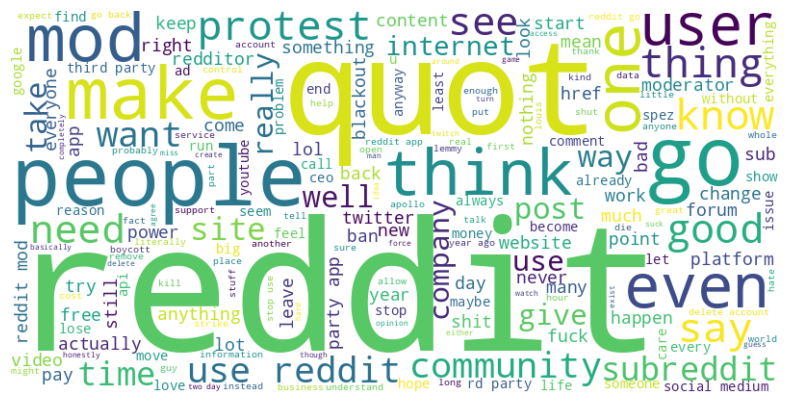

In [ ]:
# first maker all the content to be string since there might be float in the comment
rc_sentiment['comment final'] = rc_sentiment['comment final'].astype(str)
# second make all the comments into one big chunk of string
text_chunk = ' '.join(rc_sentiment['comment final'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_chunk)
# show the wordcloud I always find cool
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Negative comments.

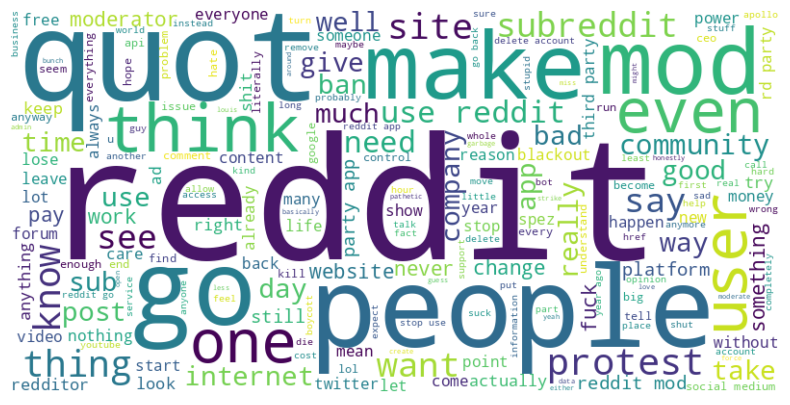

In [ ]:
rc_sentiment_neg = rc_sentiment.loc[rc_sentiment['roberta_sentiment']=='negative']
text_chunk2 = ' '.join(rc_sentiment_neg['comment final'])
wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate(text_chunk2)
# show the wordcloud I always find cool
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.show()

Positive comments.

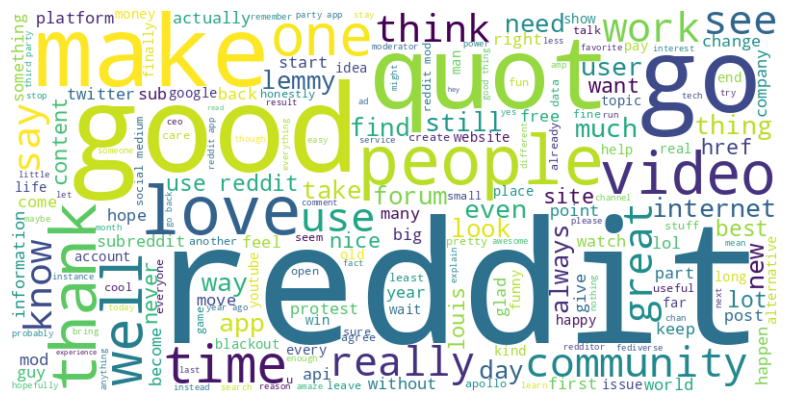

In [ ]:
rc_sentiment_pos = rc_sentiment.loc[rc_sentiment['roberta_sentiment']=='positive']
text_chunk3 = ' '.join(rc_sentiment_pos['comment final'])
wordcloud3 = WordCloud(width=800, height=400, background_color='white').generate(text_chunk3)
# show the wordcloud I always find cool
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis('off')
plt.show()


From the above wordcloud image, the most frequent words are 'reddit', 'people', 'quot', 'protest', 'think', etc. They may not, except 'protest', have a direct link to the sentiments, but if we look closer, you can see vocabularies like, 'f**k', 'issue', 'stop', 'lose', 'problem' that give you a strong negative sentiment.

You can also see other platform words, such as 'Youtube', 'twitter', 'twitch', 'third party', 'social medium' that appear in the wordcloud. Those comments might be about the comparison across social media platforms.

'Subreddit', 'people', 'community', 'redditor', 'company', and 'platform' -- these words are in the wordcloud and may indicate that those comments are mainly talking about how this policy will have an impact on a great numebr of people instead of just some individuals.

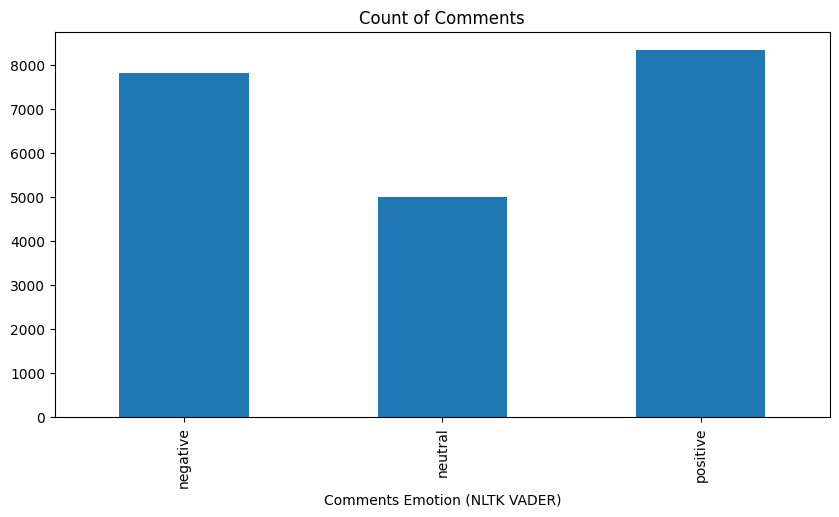

In [ ]:
ax_nltk = rc_sentiment['sentiment'].value_counts().sort_index()\
.plot(kind ='bar',title ='Count of Comments',figsize=(10,5))
ax_nltk.set_xlabel('Comments Emotion (NLTK VADER)')
plt.show()

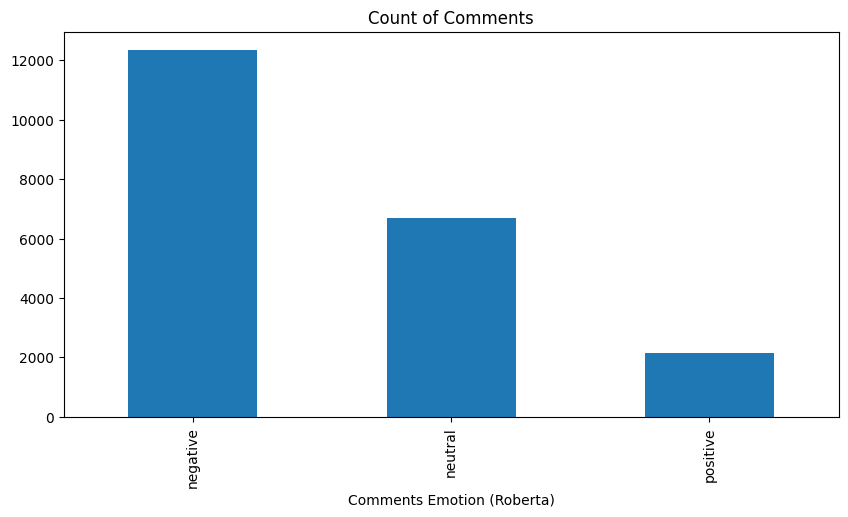

In [ ]:
ax_ro = rc_sentiment['roberta_sentiment'].value_counts().sort_index()\
.plot(kind ='bar',title ='Count of Comments',figsize=(10,5))
ax_ro.set_xlabel('Comments Emotion (Roberta)')
plt.show()

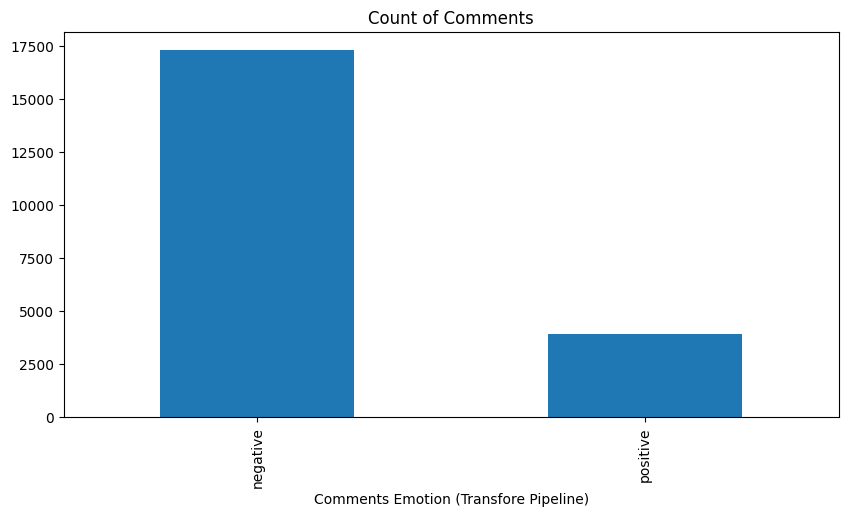

In [ ]:
ax_pi = rc_sentiment['sentiment (pipeline)'].value_counts().sort_index()\
.plot(kind ='bar',title ='Count of Comments',figsize=(10,5))
ax_pi.set_xlabel('Comments Emotion (Transfore Pipeline)')
plt.show()

So by comparing the three barplots from above, we can confirm that most comments are of negative contents. NLTKK's VADER does not consider context, so many sarcastic comments that are negative are considered to be postive. However, by using the transformer pipeline and Roberta Transformer, we can see contexts are very crucial in determing the sentiments!

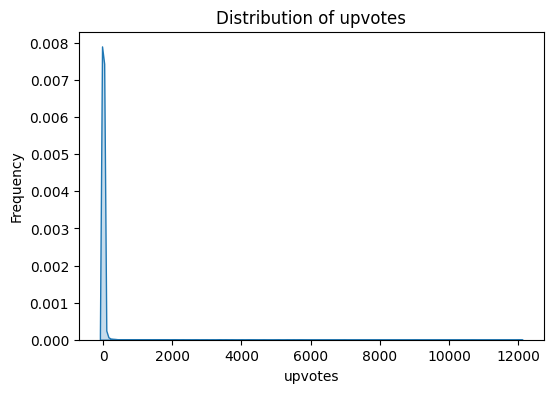

<ipython-input-12-15ef78f1e91e>:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=rc_sentiment[column], fill=True)


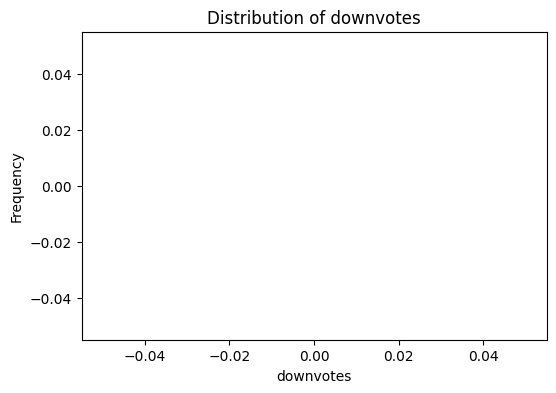

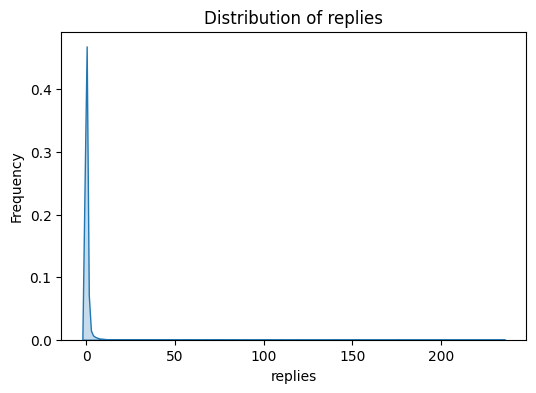

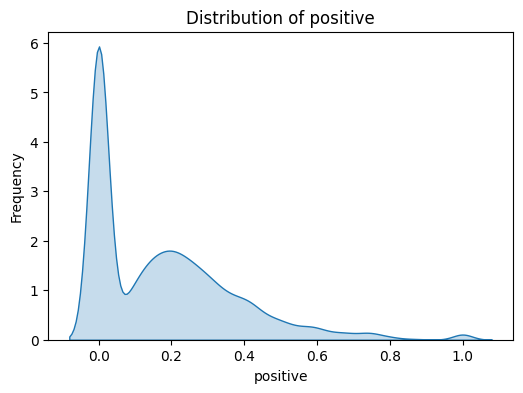

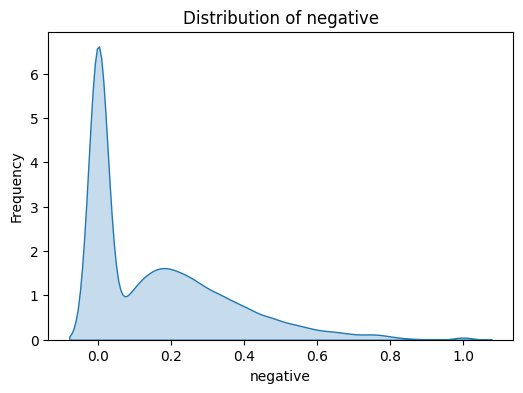

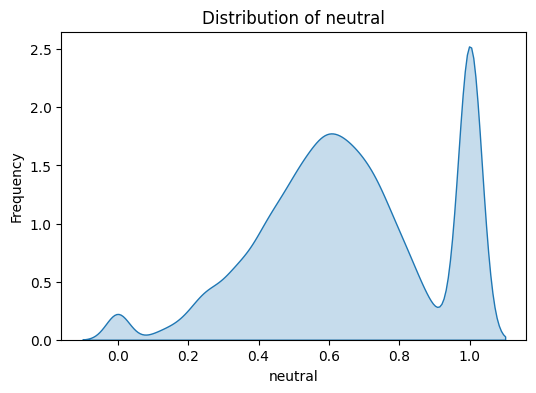

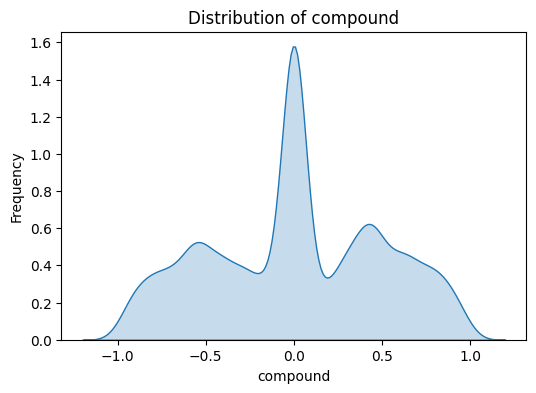

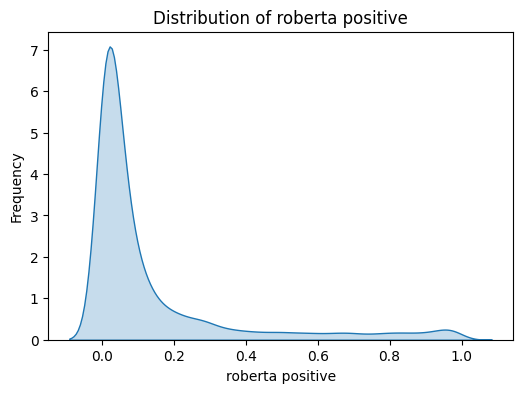

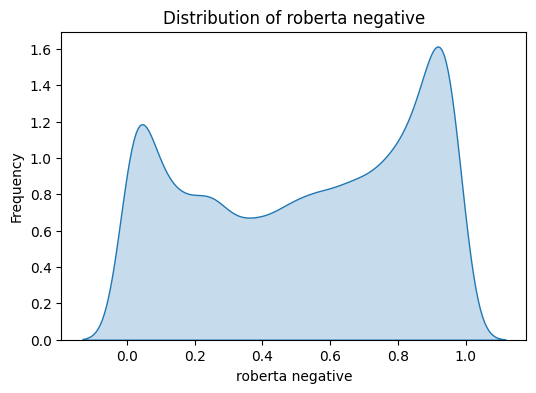

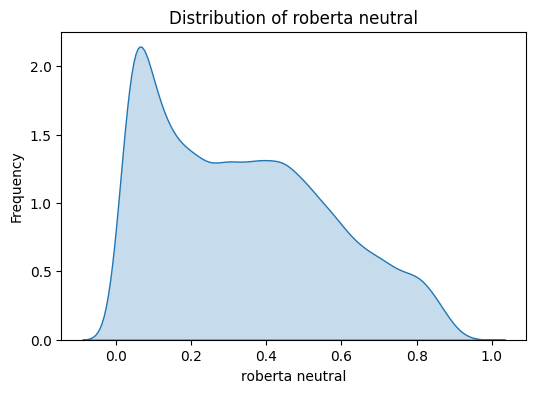

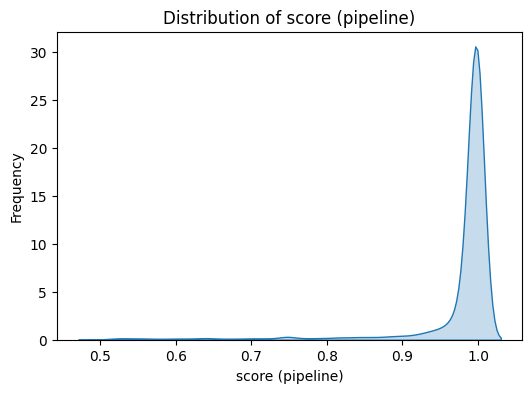

In [ ]:
cols = ['upvotes','downvotes','replies','positive','negative','neutral','compound','roberta positive','roberta negative','roberta neutral','score (pipeline)']
for column in cols:
    plt.figure(figsize=(6, 4))  # Adjust the figsize as needed
    sns.kdeplot(data=rc_sentiment[column], fill=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

From the above distributions, most of them have a skewed distribution. If we have a closer look at the distribution of compound score for NLTK's VADER, that could behave like a normal distribution if in the future we have more videos/comments about how people react to this change of policy. But we can still perfom a normality test to see how close the distribution is right now to the normal distribution.


#### Statistical Tests: Shaprio Wilk test and MannWhitney U test.

In [ ]:
shapiro(rc_sentiment['compound'])

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9698495268821716, pvalue=0.0)

 The test statistic of 0.9698 is not informative on its own; its interpretation depends on the critical values associated with the large sample size, which is greater than 20k, and significance level. A <0.05 p-val means we can reject the null hypothesis that the distribution is a normal distribution. Hence, we need to draw a QQ plot here.

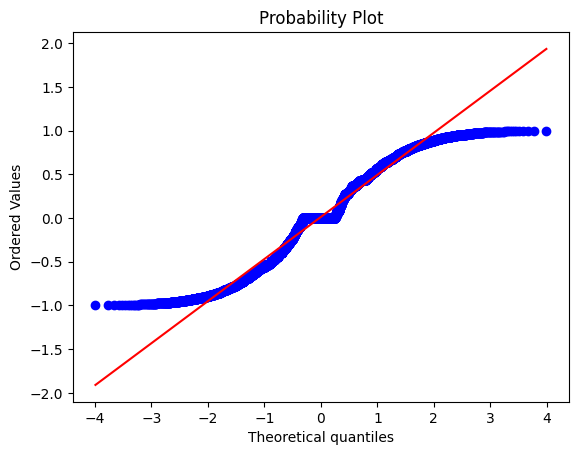

In [ ]:
measurements = (rc_sentiment['compound'])
stats.probplot(measurements, dist="norm", plot=pylab)
pylab.show()

This clearly proves that compound scores by VADER is not a normal distribution.

We can also see the VADER scores and Roberta scores by categories. But first we need to define a Roberta score and then see the distribution. The rules can be defined as follow:

Since the sum of Roberta positive, negative, and neutral is 1, we can assign a value to each category. In other words, we assign 1 to positive, -1 to negative, and 0 to neutral. In this way, we know that the range of a Roberta score is [-1,1], and -1 Roberta score means the comment is super negative. 1 means super positive. 0 means absolutely neutral and unbiased.

After this, we can also perform tests that can compare two distributions and see how different they are. For instance, how similar are the distirbutions of Roberta positive and the NLTK VADER's positive scores? They look alike.

Define Roberta's scores:

In [ ]:
roberta_score = []
for i, row in rc_sentiment.iterrows():
  temp = 1 * row['roberta positive'] + (-1) * row['roberta negative'] + 0 * row['roberta neutral'] # calculate the self defined Roberta score
  roberta_score.append(temp)
rc_sentiment['roberta score'] = roberta_score

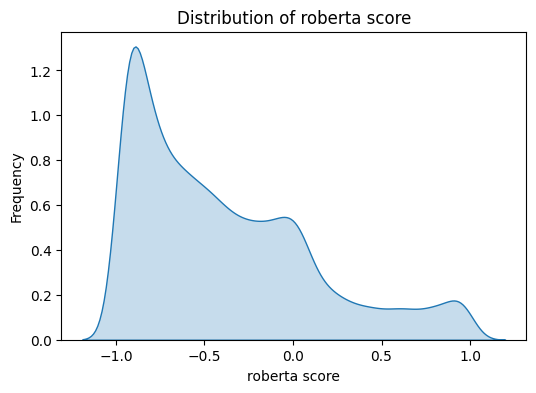

In [ ]:
plt.figure(figsize=(6, 4))  # Adjust the figsize as needed
sns.kdeplot(data=rc_sentiment['roberta score'], fill=True)
plt.title('Distribution of roberta score')
plt.xlabel('roberta score')
plt.ylabel('Frequency')
plt.show()

If we see VADER's scores and Roberta's scores by categories:

Because VADER considers a comment to be neutral onlly if the compound score is a hard 0. So for the neutral category, there will be no variance for the distribution. It is not meaningful then to see the distribution of compound scores of neutral comment. We will only see the distribution of compound scores of negative and positive comments.

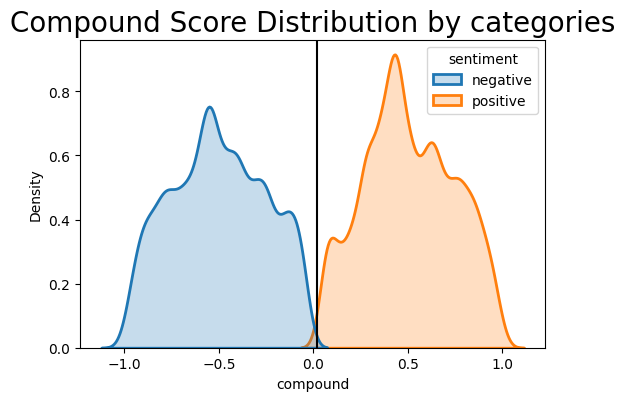

In [ ]:
pos_neg_comp = rc_sentiment.loc[(rc_sentiment['sentiment']=='positive')|(rc_sentiment['sentiment']=='negative')]
plt.figure(figsize = (6,4))
sns.kdeplot(data=pos_neg_comp,x = "compound", hue = "sentiment", fill = True, linewidth = 2)
plt.axvline(pos_neg_comp["compound"].mean(), c = "black")
plt.title("Compound Score Distribution by categories",size =20)
plt.show()

In [ ]:
pos_comp = rc_sentiment.loc[(rc_sentiment['sentiment']=='positive')]
neg_comp = rc_sentiment.loc[(rc_sentiment['sentiment']=='negative')]
print('pos',shapiro(pos_comp['compound']))
print('neg',shapiro(neg_comp['compound']))

pos ShapiroResult(statistic=0.9785890579223633, pvalue=1.404768921984909e-33)
neg ShapiroResult(statistic=0.9735137224197388, pvalue=1.0882997040654553e-35)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


For both the positive and negative compound scores distribution, they are not normal since the p values are smaller than 0.05. We reject the null hypothesis and confirm that they are not normally distributed.

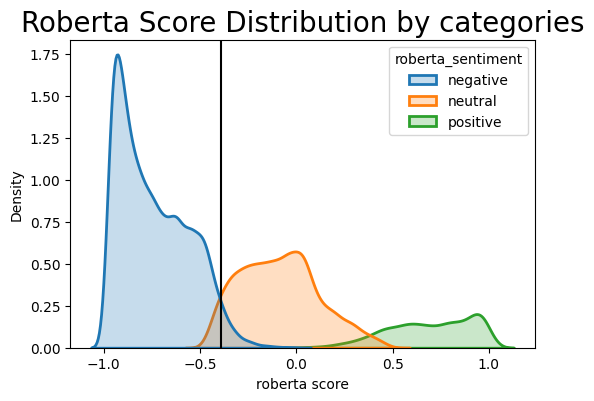

In [ ]:
plt.figure(figsize = (6,4))
sns.kdeplot(data=rc_sentiment,x = "roberta score", hue = "roberta_sentiment", fill = True, linewidth = 2)
plt.axvline(rc_sentiment["roberta score"].mean(), c = "black")
plt.title("Roberta Score Distribution by categories",size =20)
plt.show()

This by-category graph let us come to the conclusion that Roberta transformer can be more firmative in deciding if a comment is negative or positive. As you see for both nagtive and positive scores distribution for Roberta scores, they are skewed to the left and skewed to the right. That means Roberta believes some comments are definetly more likely to be considered as either negative or positive.

Nevertheless, VADER have normal like distributions for both negative and positive scores distributions, meaning a bit more hesitant than Roberta transformer.

Also, we can see that the overall distribution of Roberta scores is very similar to the distribution of Roberta's negative comments. That means the majority of comments are negative, which corresponds to our previous histogram plots.

Now let's compare distribution of roberta_positive score (not roberta score with the postive tag) and the distribution of positive score by VADER (not compound score with the positive tag) through.

In [ ]:
# Perform Mann-Whitney U Test
mwu, p_val_mwu = mannwhitneyu(rc_sentiment['positive'], rc_sentiment['roberta positive'], alternative='two-sided')
print("Mann-Whitney U statistic:", mwu)
print("p-value:", p_val_mwu)
# Decide based on p-value and significance level
alpha = 0.05
if p_val_mwu < alpha:
    print("Reject the null hypothesis: There is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the groups.")

Mann-Whitney U statistic: 223201604.0
p-value: 0.3469110433594449
Fail to reject the null hypothesis: There is no significant difference between the groups.


In [ ]:
# Perform Mann-Whitney U Test
mwu2, p_val_mwu2 = mannwhitneyu(rc_sentiment['negative'], rc_sentiment['roberta negative'], alternative='two-sided')
print("Mann-Whitney U statistic:", mwu2)
print("p-value:", p_val_mwu2)
# Decide based on p-value and significance level
if p_val_mwu2 < alpha:
    print("Reject the null hypothesis: There is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the groups.")

Mann-Whitney U statistic: 75514677.0
p-value: 0.0
Reject the null hypothesis: There is a significant difference between the groups.


Mann Whitney U test is performed when we do not have an assumption of the population distribution from which the sample is drawn. We do this test here since mostly likely that the population distribution of either sentiment is not Gaussian distributed.

So Mann Whitney U test allows us to compare two skewed independent groups of data. The process is like this:

1. Form hypothesis. Null/H0: there is no significant difference between the two distributions. Alternative/H1: there is a significant difference between the two distributions.

2. Rank the dataset by merging two groups of data together. If tie, assign the average rank. Then separate the ranked data into two original and respective groups.

3. Calculate the sum of the rank and the numebr of data for each group.

4. Then use the formula and find the p value in the talbe.

  U1 = n1 * n2 + (n1 * (n1 + 1)) / 2 - R1

  U2 = n1 * n2 + (n2 * (n2 + 1)) / 2 - R2

  U = min(U1, U2)

5. If p val < 0.05, then we reject the null, saying there's a significant difference between two groups. Otherwise, we fail to reject the null, sayting there's no significant difference between two groups.

So based on the results we have above, the roberta negative scores and VADER's negative scores distributions are different; whereas there's no difference between the roberta positive scores and VADER's positive scores distributions.

This might indicate that both VADER and Roberta can recognize positive sentiment in the same way, but VADER will consider some of the sarcastic comments (which is relatively rarer) to be positive and those data will be at the end of the distirbution. They discern the negative sentiments a bit differently, and Roberta is more confident in deciding the degree of negative of a comment.  

#### Text Classification and Anlysis through Spark

In [ ]:
spark = SparkSession.builder.appName('reddit').getOrCreate()
spark

Query data stored in the cloud.

In [ ]:
rc_sentiment_spark = spark.read.option("header", "true").csv("/content/drive/MyDrive/data/reddit_api_comments_scores_all.csv") # option makes the first row of csv to be header
rc_sentiment_spark.show()
print('Num of rows: ',rc_sentiment_spark.count())

+--------------------+-------+---------+-------+--------------------+------------------------+--------------------+--------+--------+-------+--------+---------+----------------+----------------+---------------+--------------------+------------------+-----------------+
|             comment|upvotes|downvotes|replies|      comment before|comment withno stopwords|       comment final|positive|negative|neutral|compound|sentiment|roberta positive|roberta negative|roberta neutral|sentiment (pipeline)|  score (pipeline)|roberta_sentiment|
+--------------------+-------+---------+-------+--------------------+------------------------+--------------------+--------+--------+-------+--------+---------+----------------+----------------+---------------+--------------------+------------------+-----------------+
|you have to laugh...|    0.0|      0.0|    0.0|You have to laugh...|    laugh moderators ...|laugh moderator e...|   0.129|   0.226|  0.645| -0.4019| negative|     0.013057428|      0.88577384

In [ ]:
rc_sentiment_spark = rc_sentiment_spark.select(['comment','comment final','roberta_sentiment'])
rc_sentiment_spark.show()

+--------------------+--------------------+-----------------+
|             comment|       comment final|roberta_sentiment|
+--------------------+--------------------+-----------------+
|you have to laugh...|laugh moderator e...|         negative|
|but imagine not u...|imagine use ad bl...|          neutral|
|the thing about a...|thing apollo many...|         negative|
|reddit gives you ...|reddit give infor...|         negative|
|   reddit has fallen|       reddit fallen|         negative|
|with rif gone i c...|rif go finally gi...|         negative|
|reddit has all of...|reddit relevance ...|          neutral|
|for the big subs ...|big sub go privat...|          neutral|
|this whole reddit...|whole reddit prot...|         negative|
|you mean to tell ...|mean tell people ...|          neutral|
|just stop using r...|     stop use reddit|         negative|
|peotesting for  d...|peotesting day ge...|         negative|
|you should cover ...|cover android slo...|          neutral|
|reddit 

In [ ]:
# drop empty rows
rc_sentiment_spark = rc_sentiment_spark.na.drop()
print('Num of rows: ',rc_sentiment_spark.count())

Num of rows:  21033


Tokenize the sentences that are already cleaned before.

In [ ]:
from pyspark.ml.feature import Tokenizer
# Convert a column to string
rc_sentiment_spark = rc_sentiment_spark.withColumn("comment final", rc_sentiment_spark["comment final"].cast("string"))
tokenizer = Tokenizer(inputCol="comment final", outputCol="tokens final")
rc_sentiment_spark_tokens = tokenizer.transform(rc_sentiment_spark)
# rc_sentiment_spark_tokens = rc_sentiment_spark_tokens.withColumn("comment final", rc_sentiment_spark_tokens["comment final"].cast("string"))
rc_sentiment_spark_tokens.show()

+--------------------+--------------------+-----------------+--------------------+
|             comment|       comment final|roberta_sentiment|        tokens final|
+--------------------+--------------------+-----------------+--------------------+
|you have to laugh...|laugh moderator e...|         negative|[laugh, moderator...|
|but imagine not u...|imagine use ad bl...|          neutral|[imagine, use, ad...|
|the thing about a...|thing apollo many...|         negative|[thing, apollo, m...|
|reddit gives you ...|reddit give infor...|         negative|[reddit, give, in...|
|   reddit has fallen|       reddit fallen|         negative|    [reddit, fallen]|
|with rif gone i c...|rif go finally gi...|         negative|[rif, go, finally...|
|reddit has all of...|reddit relevance ...|          neutral|[reddit, relevanc...|
|for the big subs ...|big sub go privat...|          neutral|[big, sub, go, pr...|
|this whole reddit...|whole reddit prot...|         negative|[whole, reddit, p...|
|you

Encode the tokenized words so that we can pass the vectors into the model.

In [ ]:
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import col
count = CountVectorizer(inputCol="tokens final", outputCol="vectors")
model = count.fit(rc_sentiment_spark_tokens)
rc_sentiment_spark_vectors = model.transform(rc_sentiment_spark_tokens)
rc_sentiment_spark_vectors.show()

+--------------------+--------------------+-----------------+--------------------+--------------------+
|             comment|       comment final|roberta_sentiment|        tokens final|             vectors|
+--------------------+--------------------+-----------------+--------------------+--------------------+
|you have to laugh...|laugh moderator e...|         negative|[laugh, moderator...|(17408,[6,14,30,5...|
|but imagine not u...|imagine use ad bl...|          neutral|[imagine, use, ad...|(17408,[4,27,101,...|
|the thing about a...|thing apollo many...|         negative|[thing, apollo, m...|(17408,[0,1,3,4,7...|
|reddit gives you ...|reddit give infor...|         negative|[reddit, give, in...|(17408,[0,6,19,26...|
|   reddit has fallen|       reddit fallen|         negative|    [reddit, fallen]|(17408,[0,5725],[...|
|with rif gone i c...|rif go finally gi...|         negative|[rif, go, finally...|(17408,[0,2,46,10...|
|reddit has all of...|reddit relevance ...|          neutral|[re

Create label. Nagtive is 0. Positive is 1.

In [ ]:
# Define the conditions and values for creating the label column
from pyspark.sql.functions import when
rc_sentiment_spark_vectors = rc_sentiment_spark_vectors.withColumn("label", when(rc_sentiment_spark_vectors.roberta_sentiment == "negative", 0).otherwise(1))
rc_sentiment_spark_vectors.show(5)

+--------------------+--------------------+-----------------+--------------------+--------------------+-----+
|             comment|       comment final|roberta_sentiment|        tokens final|             vectors|label|
+--------------------+--------------------+-----------------+--------------------+--------------------+-----+
|you have to laugh...|laugh moderator e...|         negative|[laugh, moderator...|(17408,[6,14,30,5...|    0|
|but imagine not u...|imagine use ad bl...|          neutral|[imagine, use, ad...|(17408,[4,27,101,...|    1|
|the thing about a...|thing apollo many...|         negative|[thing, apollo, m...|(17408,[0,1,3,4,7...|    0|
|reddit gives you ...|reddit give infor...|         negative|[reddit, give, in...|(17408,[0,6,19,26...|    0|
|   reddit has fallen|       reddit fallen|         negative|    [reddit, fallen]|(17408,[0,5725],[...|    0|
+--------------------+--------------------+-----------------+--------------------+--------------------+-----+
only showi

Find TF-IDF. Take the importance of the word in a sentence into account.

In [ ]:
from pyspark.ml.feature import IDF
idf = IDF(inputCol="vectors", outputCol="features")
idfModel = idf.fit(rc_sentiment_spark_vectors)
rescaledData = idfModel.transform(rc_sentiment_spark_vectors)
rescaledData.select("label", "features").show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|(17408,[6,14,30,5...|
|    1|(17408,[4,27,101,...|
|    0|(17408,[0,1,3,4,7...|
|    0|(17408,[0,6,19,26...|
|    0|(17408,[0,5725],[...|
|    0|(17408,[0,2,46,10...|
|    1|(17408,[0,448,881...|
|    1|(17408,[0,2,7,13,...|
|    0|(17408,[0,1,2,5,8...|
|    1|(17408,[0,1,2,3,6...|
|    0|(17408,[0,4,70],[...|
|    0|(17408,[6,13,191,...|
|    1|(17408,[2,277,362...|
|    0|(17408,[0,6,46,47...|
|    1|(17408,[9,42,56,6...|
|    0|(17408,[8,72,98,1...|
|    0|(17408,[0,14,51,6...|
|    0|(17408,[156,259,3...|
|    0|(17408,[0,17,236,...|
|    1|(17408,[0,3,4,6,7...|
+-----+--------------------+
only showing top 20 rows



Balance the dataset.

In [ ]:
df_final = rescaledData.select("label", "features")
seed = 42  # set seed for reproducibility
train, test = df_final.randomSplit([0.7,0.3],seed)
train.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 6200|
|    0| 8684|
+-----+-----+



In [ ]:
train_1= train.where(col('label')==1).sample(True, 1.4, seed = 42)
train_0=train.where(col('label')==0)
train_final = train_0.union(train_1)

In [ ]:
train_final.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0| 8684|
|    1| 8625|
+-----+-----+



Modeling with logistic regression and naive bayes.

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol = "label", featuresCol = "features",maxIter = 10)
model = lr.fit(train)

In [ ]:
test_raw = test.select(['features'])
pred = model.transform(test_raw)

In [ ]:
pred.show()

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|(17408,[0],[0.789...|[-1.3742797941384...|[0.20192926128137...|       1.0|
|(17408,[0,1,2,3,4...|[9.07962247902958...|[0.99988604836308...|       0.0|
|(17408,[0,1,2,3,4...|[22.4569369580532...|[0.99999999982336...|       0.0|
|(17408,[0,1,2,3,4...|[78.6758031902945...|           [1.0,0.0]|       0.0|
|(17408,[0,1,2,3,4...|[25.4769535869643...|[0.99999999999138...|       0.0|
|(17408,[0,1,2,3,4...|[47.3686762609796...|           [1.0,0.0]|       0.0|
|(17408,[0,1,2,3,4...|[-12.952864600405...|[2.36941618211139...|       1.0|
|(17408,[0,1,2,3,4...|[58.1466225898051...|           [1.0,0.0]|       0.0|
|(17408,[0,1,2,3,4...|[91.4589955372652...|           [1.0,0.0]|       0.0|
|(17408,[0,1,2,3,4...|[145.450169491572...|           [1.0,0.0]|       0.0|
|(17408,[0,1

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
eval = BinaryClassificationEvaluator(labelCol = "prediction", metricName='areaUnderROC')
areaUnderROC = eval.evaluate(pred)
print(f"The testing areaUnderROC of the Logistic Regression model is: {areaUnderROC}")

The testing areaUnderROC of the Logistic Regression model is: 0.9999996815154091


In [ ]:
pred_pd = pred.toPandas()
pred_pd.head()

,features,rawPrediction,probability,prediction
0,"(0.7895990216051979, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.374279794138443, 1.374279794138443]","[0.2019292612813779, 0.7980707387186221]",1.0
1,"(6.316792172841583, 5.079850329779059, 3.68753...","[9.079622479029581, -9.079622479029581]","[0.9998860483630835, 0.00011395163691652055]",0.0
2,"(3.1583960864207916, 5.079850329779059, 3.6875...","[22.456936958053255, -22.456936958053255]","[0.9999999998233653, 1.76634706861023e-10]",0.0
3,"(7.106391194446781, 15.239550989337175, 1.8437...","[78.67580319029457, -78.67580319029457]","[1.0, 0.0]",0.0
4,"(1.5791980432103958, 15.239550989337175, 1.843...","[25.476953586964378, -25.476953586964378]","[0.9999999999913802, 8.619771563189715e-12]",0.0


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
test_pd = test.toPandas()
y_true = test_pd['label']
y_pred = pred_pd['prediction']
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.73      0.76      3569
           1       0.66      0.74      0.70      2580

    accuracy                           0.73      6149
   macro avg       0.73      0.73      0.73      6149
weighted avg       0.74      0.73      0.73      6149



In [ ]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(featuresCol="features", labelCol="label", predictionCol="prediction")
model2 = nb.fit(train)

In [ ]:
pred2 = model2.transform(test_raw)
eval2 = BinaryClassificationEvaluator(labelCol = "prediction", metricName='areaUnderROC')
areaUnderROC2 = eval2.evaluate(pred2)
print(f"The testing areaUnderROC of the Logistic Regression model is: {areaUnderROC2}")
pred2_pd = pred2.toPandas()
y_pred2 = pred2_pd['prediction']
print(classification_report(y_true, y_pred2))

The testing areaUnderROC of the Logistic Regression model is: 0.5797677232634468
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      3569
           1       0.65      0.67      0.66      2580

    accuracy                           0.71      6149
   macro avg       0.71      0.71      0.71      6149
weighted avg       0.71      0.71      0.71      6149



Based on the above results, logistic regression performs better here.

<a id="section-6"></a>
### Summary


In this notebook, we go through a conprehensive and thorough analysis of recent Reddit's API charging changes.

We did visualizations, connecting to Youtube API, sentiment analysis (VADER, Roberta transformer, pipeline), Shapiro Wilk test, Mannwhitney U test, text classifications using logistic regression and Naive Bayes through PySpark.

Let's also answer some of the questions we have before.

1.   What are the major sentiments of this topic?

  Mostly negative. People are not happy with the change. A lot of people are also being sarcastic regarding to this issue.

2.   Is it a good move or a bad move for Reddit?

  Generally not a good move to users as the comments are fulfilled with the negative sentiment. However, it could be a good move for Reddit as it charges money, but we will need some other data to find this out.

B. Hypothesis


1.   Angry and disappointment are the main sentiments of the comments.

  We can say negative emotions are very common.
2.   People will use them less frequently according to their comments; they will surf other websites as a substitution.

  According to comments, there are indeed some mentioning of other platforms or comparison to other platforms. Some people may feel fine, but there's a portion of people who will use other social media platforms more often than Reddit, according to their comments.
3.   It's in general a bad move at first, but the problem will be sorted out as time goes by since users rely on Reddit too much. Reddit's contents are great in many ways.

  This could be true for some people who find no issue with Reddit's charging.
4.   Sarcasm in comments occur also quite frequently.

  Indeed. As Roberta transformer model can detect fewer positive comments compared to NLTK's VADER, which does not consider the context and therefore no sarcasm.


It's been a great time doing this, and I enjoy doing it every second. Hope you also like this notebook. Enjoy! Cheers!